Last updated on 10th October 2017

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.io as sio
import matplotlib.pyplot as plt
from datetime import datetime 

# Neural Networks

In the previous exercise 3, we implemented feedforward propagation for a  neural network and applied it to predict handwritten digits using the provided weights. 

In this exercise 4, we do feedforward propagation again with some slight improvements, followed by an implementation of the backpropagation algorithm which lets us *learn* the weights for the neural network. We must therefore implement the cost and gradient functions of the neural network in order for the backpropagation algorithm to use them in computing the optimal weights.

## Reading in and visualizing the dataset

The same routine here as used in exercise 3.

In [2]:
data = sio.loadmat("./ex4data1.mat")
X = data["X"]
y = data["y"].flatten()
print("Shape of X is {}.\nShape of y is {}.".format(X.shape ,y.shape))

Shape of X is (5000, 400).
Shape of y is (5000,).


In [3]:
X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

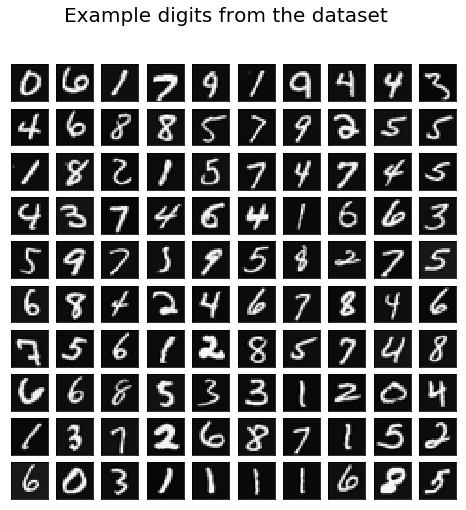

In [4]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize = (8,8))
for i in range(0,10):
    for j in range(0,10):
        row = np.random.randint(low=0, high =5000)
        # corrected to be named as gray so that truly matches the convention where pixel value 0 is black, 255 is white
        # if not originally was using Greys_r which is kinda weird...
        axes[i][j].imshow(X[row,:].reshape(20,20).T, cmap="gray") 
        # This could have also been accomplished with two separate lines:
        # axes[i][j].xticks=[] and axes[i][j].yticks=[]
        axes[i][j].set(xticks=[], yticks=[])
fig.suptitle("Example digits from the dataset", fontsize = 20)
fig

## Model Representation

Our neural network model has 3 layers, an input layer, a hidden layer and an output layer. 
<img src="img/neural_network_model.png" width="450">
The input, hidden and output layers have 400, 25 and 10 units respectively (excluding the bias units which always supply +1). 400 units in the input layer is necessary in order to accomodate the 400 pixel values (features) that make up each image. 

We are given the pre-trained network parameters $\Theta^{(1)}$ and $\Theta^{(2)}$.

In [5]:
weights = sio.loadmat("./ex4weights.mat")
Theta1 = weights["Theta1"]
Theta2 = weights["Theta2"]
print("Shape of Theta1 is {}.\nShape of Theta2 is {}.".format(Theta1.shape ,Theta2.shape))

Shape of Theta1 is (25, 401).
Shape of Theta2 is (10, 26).


## Feedforward propagation and cost function

Feedforward propagation here follows closely from the implementation [Exercise 3](https://nbviewer.jupyter.org/github/kohaugustine/Machine-Learning-Coursera/blob/master/machine-learning-ex3/Programming%20Exercise%203%20-%20Multi-class%20Classification%20and%20Neural%20Networks.ipynb). Additionally, we now implement the cost function for the neural network to support the implementation of the backpropagation algorithm further below. 

#### Notes for `recode_labels()` function

This function recodes label vector `y` by mapping the class label of each image to a vector in $\mathbb{R}^{K}$ where $K$ is the number of labels/classes, $K=10$ in this exercise. This changes `y` from a $5000$ by $1$ vector to a $5000$ by $10$ matrix. Each row of the matrix represents the recoded labels for an image. If a $1$ is indicated in the particular column, then that column's index is the class label of the image, and every other column should be 0 (since an image can only belong to one distinct class).

In [6]:
# Recodes the ground truth vector to be just ones and zeros
def recode_labels(y,num_labels):
    y_recode = np.zeros((len(y), num_labels))
    # iterate over each training example image one by one (each row)
    for instance in range(0,len(y)):
        # Dig into the index on the ground truth label vector, index out the class label, minus that by
        # 1 in order to match python indexing convention starts from 0, and that gives us the position
        # where a 1 should be placed to indicate the class
        y_recode[instance][y[instance] - 1] = 1
    return y_recode

Check to ensure that the recoded output is equivalent to the original non-recoded ground truth labels we convert the recoded output back to ground truth vector.

In [7]:
print("Recoded labels equivalent to original labels: ", np.all(np.argmax(recode_labels(y,10),axis = 1)+1 == y))
print(y[0:5])
print(recode_labels(y,10)[0:5])

Recoded labels equivalent to original labels:  True
[10 10 10 10 10]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


**Building block functions** for the neural network, same as in Programming Exercise 3.

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def add_bias_term(X):
    ones_row = np.ones(_X.shape[0])
    _X_bias = np.vstack((ones_row, _X.T)).T
    return _X_bias

def layer1_to_layer2_output(theta,X):
    return sigmoid(theta@X)

def layer2_to_layer3_output(theta,X):
    return sigmoid(theta@X).T

#### `reshape_weights()` function implementation notes
Reconstructs the neural network weight matrices from the flattened array of parameters. Respects row-major order convention in python.

In [9]:
# Why is it required for us to pass all the neural network weights as a flattened vector???
# Helper function that reshapes all neural network parameters
# Provide all neural network sizes without bias term
def reshape_weights(nn_params, input_layer_size, hidden_layer_size, num_labels):
    # Theta1 weights
    # Note that the upper bounds on the indexing is not inclusive, so its one less than the computed value
    T1 = nn_params[0: hidden_layer_size* (input_layer_size+1)].reshape(hidden_layer_size, input_layer_size + 1)
    # Theta2 weights
    T2 = nn_params[hidden_layer_size*(input_layer_size+1) : ].reshape(num_labels, hidden_layer_size+1)
    return T1, T2
    

#### `feedforward()` function implementation notes

Performs a forward pass of the input data through the neural network, and outputs the predictions without recoding to vector of values $0$ or $1$. Each image is represented by a row whose individual values are the probabilities that the image belongs to a specific class as indicated by the column index of that particular value.

In [10]:
# Performs the forward pass of the neural network, and outputs the predictions as recoded vectors
def feedforward(X, Theta1, Theta2):
    X_bias = add_bias_term(X)
    layer2_out = layer1_to_layer2_output(Theta1,X_bias)
    layer2_out_bias = add_bias_term(layer2_out.T)  # Transpose the matrix in order to match the dimension requirements
    hyp_out = layer2_to_layer3_output(Theta2,layer2_out_bias) # output of the hypothesis
    return hyp_out

#### compute_cost_regularized() implementation notes

TODO: explain

In [11]:
def compute_cost_regularized(forwardpass_predictions, y_recoded, num_instances, Theta1,Theta2, lda): # number of instances or images in training dataset
    regterm = lda/(2*num_instances) * (np.sum(Theta1**2) + np.sum(Theta2**2))
    sumall = np.sum(-y_recoded *np.log(forwardpass_predictions) - (1-y_recoded) * np.log(1-forwardpass_predictions))
    return (1/num_instances * sumall) + regterm

### Cost functions

Using the earlier basic functions, **`nn_cost_with_regterm()`** function implements:

$$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left[-y^{(i)}_k \log ((h_\Theta (x^{(i)}))_k) - (1 - y^{(i)}_k)\log (1 - (h_\Theta(x^{(i)}))_k)\right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1} \sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}} ( \Theta_{j,i}^{(l)})^2$$

This is the regularized cost function for the neural network, which is [very similar](https://math.stackexchange.com/questions/1074276/how-is-logistic-loss-and-cross-entropy-related) to the cost function for logistic regression, that was already introduced to us earlier in the course. This is not surprising, since the activation function that we have chosen for our neurons is the sigmoid/logistic function. This cost function is based on the concept of cross-entropy, and this [article]( https://www.quora.com/What-are-the-differences-between-maximum-likelihood-and-cross-entropy-as-a-loss-function) draws the connection between cross-entropy and the idea of maximum likelihood. Maximum likelihood estimation is the method through which the cost function for logistic regression was derived.

#### Implementation notes

The function performs the following steps:

1. Reshape the flattened parameters array.
- Compute a forward pass through the neural network.
- Recode the label vector.
- Compute the cost of the neural network using the recoded labels from step 3 and predictions from step 2.

If no value for the regularization parameter `lda` is passed in the call, then it defaults to `0` (regularization parameter vanishes - no regularization applied). Otherwise, if a value is passed to `lda`, then that is the value used for the regularization parameter.

In [12]:
def nn_cost_with_regterm( nn_params, X, y,input_layer_size, hidden_layer_size, num_labels, lda=None):
    if lda == None:
        lda = 0
    T1, T2 = reshape_weights(nn_params, input_layer_size, hidden_layer_size, num_labels)
    forwardpass = feedforward(X,T1,T2)
    yrec = recode_labels(y,num_labels)
    return compute_cost_regularized(forwardpass, yrec, len(y), T1,T2,lda)


#### Check correctness

Both cost functions output the correct values as expected, for the given parameters.

In [13]:
# Flatten and construct a linearized array of all parameters to pass into the nn_* functions
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))
print(nn_cost_with_regterm(nn_params, X,y,400, 25,10))
print(nn_cost_with_regterm(nn_params,X,y, 400, 25,10,1))

0.287629165161
0.384487796243


## Backpropagation

We now implement the backpropagation algorithm to compute the gradient for each weight in our neural network. 

<img src="img/backpropagation_algo.png" width="450">

Backpropagation begins first by computing a forward pass of the network. Next, it computes the error terms for the output and hidden layers, starting first from the output layer and ending at the hidden layer. We do not compute the error for the input layer.

These error terms then allow us to compute the gradients.

In [14]:
# z is the matrix of weighted inputs
def sigmoid_gradient(z):
    return (1/(1+np.exp(-z))) * (1 - 1/(1+np.exp(-z)))

TODO: Vectorize this implementation, then provide the implementation notes. Vectorization help can be found at https://stats.stackexchange.com/questions/261918/matrix-and-vector-approaches-to-backpropagation-in-a-neural-network, http://ufldl.stanford.edu/wiki/index.php/Neural_Network_Vectorization, http://ufldl.stanford.edu/wiki/index.php/Backpropagation_vectorization_hints

In [15]:
def backprop_gradient(nn_params, X, y,input_layer_size, hidden_layer_size, num_labels, lda = None):
    # reshape the vector of weights into our matrices to facilitate easier
    # computation
    Theta1, Theta2 = reshape_weights(nn_params, input_layer_size, hidden_layer_size, num_labels)
    # recode the label vector
    recodedy = recode_labels(y,num_labels)
    # Initialize the delta matrices
    Delta2 = np.zeros((Theta2.shape[0], Theta2.shape[1]))
    Delta1 = np.zeros((Theta1.shape[0],Theta1.shape[1]))

    for i in range(0, len(y)):
        # Step 1 perform forwardpass
        x_bias = np.concatenate(([1],X[i]))
        layer2_out = layer1_to_layer2_output(Theta1,x_bias)
        layer2_out_bias = np.concatenate(([1],layer2_out))
        hyp_out = layer2_to_layer3_output(Theta2,layer2_out_bias) # output of the hypothesis    
        # Step 2 
        delta3 = hyp_out - recodedy[i]
        # step 3
        sigrad = sigmoid_gradient(Theta1@x_bias) # computing gradient using weighted inputs, as per original defn
        # exclude the columm of bias terms in theta2 (why?)
        delta2 = (Theta2[:,1:].T@delta3) * sigrad  
        
        #step4 accumulated over all training examples
        Delta2 = Delta2 + delta3.reshape((len(delta3),1))@layer2_out_bias.reshape((1,len(layer2_out_bias)))
        Delta1 = Delta1 + delta2.reshape((len(delta2),1)) @ x_bias.reshape((1,len(x_bias)))

    grad1 = 1/len(y) * Delta1 if lda == None else 1/len(y) * Delta1 + (lda/len(y))*Theta1
    grad2 = 1/len(y) * Delta2 if lda == None else 1/len(y) * Delta2 + (lda/len(y))*Theta2
    return np.concatenate((grad1.flatten(), grad2.flatten()))
# As the skeleton code in the assignment states, the returned gradient should 
# be an unrolled vector

### Gradient checking

As the backpropagation is a challenging algorithm to implement, we can check its correctness by comparing the analytically computed parameters (obtained via backpropagation) with numerically computed parameters. The code that performs the numerical computation and performs the relative difference comparison is wrapped up in `check_nn_gradients.py`.

In [16]:
import check_nn_gradients as test

print("No regularization (lamdba=0)")
test.check_nn_gradients(nn_cost_with_regterm, backprop_gradient)
print("\n")
print("With regularization (lambda = 3)")
test.check_nn_gradients(nn_cost_with_regterm, backprop_gradient,lda=3)

No regularization (lamdba=0)
The analytically computed gradient (via backpropagation):
 [  1.23162247e-02   1.73828184e-04   2.61455144e-04   1.08701450e-04
   3.92471369e-03   1.90101252e-04   2.22272331e-04   5.00872547e-05
  -8.08459407e-03   3.13170587e-05  -2.17840341e-05  -5.48569864e-05
  -1.26669105e-02  -1.56130210e-04  -2.45506163e-04  -1.09164881e-04
  -5.59342547e-03  -2.00036572e-04  -2.43630220e-04  -6.32313673e-05
   3.09347722e-01   1.61067138e-01   1.47036522e-01   1.58268577e-01
   1.57616707e-01   1.47236360e-01   1.08133003e-01   5.61633717e-02
   5.19510542e-02   5.47353405e-02   5.53082757e-02   5.17752619e-02
   1.06270372e-01   5.57611045e-02   5.05568118e-02   5.38805141e-02
   5.47407215e-02   5.02929547e-02]
The numerically computed gradient:
 [  1.23162247e-02   1.73828183e-04   2.61455146e-04   1.08701448e-04
   3.92471369e-03   1.90101250e-04   2.22272334e-04   5.00872543e-05
  -8.08459407e-03   3.13170623e-05  -2.17840346e-05  -5.48569856e-05
  -1.2666910

The relative differences are all less than 1e-9, indicating that backpropagation is implemented correctly.

### Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. 
#### `rand_initialize_weights()` function implementation notes

Produces a matrix of random floats of size `L_out` rows and `L-in + 1` columns. The range of random values chosen is contrained by:

$$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$$

Page 7 of the assignment states that we should use a hardcoded value of $\epsilon_{init} = 0.12$. I clarified on the course forums that for our problem here, hardcoding a value is fine, but if we use the general form above, we should get better results. Separately, we could experiment how this value affects the performance of our neural network.

In [17]:
def rand_initialize_weights(L_in, L_out):
    epsilon_init = np.sqrt(6) / np.sqrt(L_in+L_out)
    return np.random.random((L_out, L_in + 1)) * 2 * epsilon_init - epsilon_init # add +1 to accomodate bias term

### Learning the parameters using CG optimization

In [28]:
theta1_init = rand_initialize_weights(400,25)
theta2_init = rand_initialize_weights(25,10)
params = np.concatenate([theta1_init.flatten(),theta2_init.flatten()])
lda = 1
mxit = 50

results = minimize(nn_cost_with_regterm, params, args = (X,y,400,25,10,lda),
                   method = 'CG', jac = backprop_gradient, 
                   options = {"maxiter":mxit, "disp" : True})
# Generate the training timestamp
dt = datetime.utcnow()
dtstr = dt.strftime("trained-at_%Y-%m-%d_%H%M-Hrs_maxiter-{}_lambda-{}".format(mxit,lda))
print(dtstr)

         Current function value: 0.437364
         Iterations: 50
         Function evaluations: 116
         Gradient evaluations: 116
trained-at_2017-08-26_1038-Hrs_maxiter-50_lambda-1


In [29]:
trained_weights = results.x
t1,t2 = reshape_weights(trained_weights, 400, 25, 10)

Now we perform the prediction using the parameters learned from optimization with the cost and gradient functions we implemented earlier, and we see that our accuracy is very good, around the expected $95.2\pm 1 \%$.

In [30]:
prediction = feedforward(X,t1,t2)
np.mean(np.argmax(prediction, axis = 1)+1 == y) *100

96.819999999999993

## Visualizing the hidden layer

We can visualize the representations learned by the hidden layer units, and we can observe that the different neurons have learned to "look out" for different features at different places in the image.

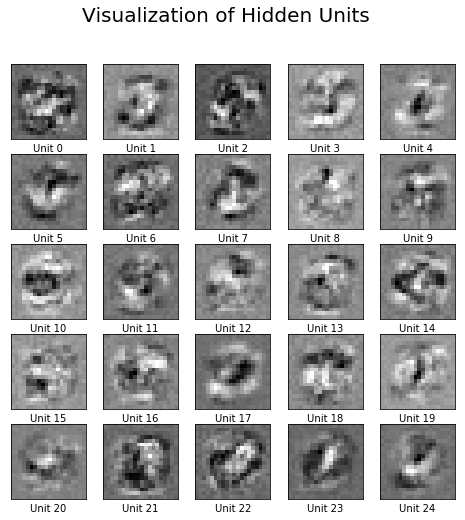

In [31]:
t1nobias = t1[:,1:] # remove the bias term from Theta1
fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (8,8))
for i in range(0,5):
    for j in range(0,5):
        # compute the index for selecting the particular unit's weights
        unitno = j + i*5 
        axes[i][j].imshow(t1nobias[unitno].reshape(20,20).T, cmap="gray")
        axes[i][j].set(xticks=[], yticks=[], xlabel = "Unit {}".format(unitno))
fig.suptitle("Visualization of Hidden Units", fontsize = 20)
fig

We write out our trained parameters and predictions to matrix market format files, for use in the other notebook on "Interpreting Neural Networks", where we will examine the model in more detail.

In [32]:
sio.mmwrite("./Theta1_{}.mtx".format(dtstr), t1)
sio.mmwrite("./Theta2_{}.mtx".format(dtstr), t2)
sio.mmwrite("./prediction_probabilities_{}.mtx".format(dtstr), prediction)